In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
class LoraModulator():
    def __init__(self, sf, bw, samples_per_chip):
        self.spreading_factor = sf
        self.bandwidth = bw
        self.samples_per_chip = samples_per_chip
        self.chips_number = 2**sf
        self.symbol_duration = 2**sf / bw
        self.frequency_slope = bw / self.symbol_duration
    
    def generate_timeline(self, symbols_number = 1):
        '''
        This method generates a discrete timeline for the transmission of a given number of symbols.
        Parameters:
        symbols_number: number of symbols to be transmitted
        '''
        # spreading_factor: spreading factor
        # bandwidth: bandwidth
        # samples_per_chip: samples per chip

        symbol_time = (2**self.spreading_factor) / self.bandwidth

        # Number of evenly-spaced time samples.
        # A plus one has to be added in order correctly generate the timeline
        num_time_samples= (2**self.spreading_factor) * self.samples_per_chip * symbols_number + 1

        timeline =  np.linspace(0, symbol_time * symbols_number, num_time_samples)

        # Remove the last element of the timeline due to the discretization
        timeline = timeline[:-1]

        return timeline
    
    def generate_frequency_evolution(self, timeline, symbols):
        '''
        This function generates the linear frequency evolution for a given set of symbols, with the given timeline as input.
        Parameters:
        timeline: discrete timeline
        symbols: array of symbols to be transmitted
        '''
        # We only need a single symbol period to generate the frequency evolution
        timeline = timeline[:(len(timeline) // len(symbols))]
        
        frequency_slope = self.frequency_slope

        frequency_evolution = np.array([])
        
        for symbol in symbols:
            
            y_intercept = symbol * ( self.bandwidth / (2**self.spreading_factor))
            instantaneous_frequency = ( y_intercept + frequency_slope * (timeline) ) % self.bandwidth
            frequency_evolution = np.concatenate((frequency_evolution, instantaneous_frequency))

        return frequency_evolution
    
    def generate_signal(self, timeline, symbols):
        '''
        This function generates the complex signal for a given set of symbols, with the given timeline as input.
        Parameters:
        timeline: discrete timeline
        symbols: array of symbolsp
        '''
        # We only need a single symbol period to generate the signal
        timeline = timeline[:(len(timeline) // len(symbols))]

        # Multiplies by 0.5 because of the integration
        integrated_frequency_slope = np.float64(self.bandwidth / self.symbol_duration * 0.5)

        power_normalizer = 1 / np.sqrt(2**self.spreading_factor * self.samples_per_chip)

        signal = np.array([])

        for symbol in symbols:
            y_intercept = symbol * ( self.bandwidth / (2**self.spreading_factor))
            instantaneous_frequency = ( y_intercept + integrated_frequency_slope * (timeline) ) % self.bandwidth
            phase = 2 * np.pi * instantaneous_frequency * timeline
            signal_sample = power_normalizer * np.exp(1j * phase)
            signal = np.concatenate((signal, signal_sample))
    
        return signal
    
    def modulate_symbols(self, symbols, also_compute_frequency_evolution = False, plot = False):
        '''
        This function generates the timeline, the complex signal for a given array of symbols and the frequency evolution if it is also needed.
        Parameters:
        symbols: array of symbols
        also_compute_frequency_evolution: boolean to indicate if the non-integrated frequency evolution should be computed
        '''
        timeline = self.generate_timeline(len(symbols))
        signal = self.generate_signal(timeline, symbols)

        if also_compute_frequency_evolution:
            frequency_evolution = self.generate_frequency_evolution(timeline, symbols)
            return timeline, frequency_evolution, signal
        
        return timeline, signal
    
    def generate_modulation_plots(self, symbols, timeline, frequency_evolution, signal):
        '''
        This function generates the plots for a graphical representation of the modulation process.
        '''
        figure, axes = plt.subplots(2, 1, figsize=(20, 12))
        too_many_symbols = len(symbols) > 5
        symbols_txt = str(symbols) if not too_many_symbols else str(symbols[:4]) + '...'
        figure.suptitle('LoRa Modulation of the symbols: '+symbols_txt, fontsize=20)
        axes[0].plot(timeline, frequency_evolution)
        axes[0].set_title('Frequency evolution across time of the signal to be transmitted')
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Frequency (Hz)')
        axes[1].plot(timeline, np.real(signal))
        axes[1].plot(timeline, np.imag(signal))
        axes[1].set_title('Real and imaginary parts of the signal to be transmitted')
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Amplitude')
        return figure



    


In [93]:
class LoraDemodulator():
    def __init__(self, sf, bw, samples_per_chip):
        self.spreading_factor = sf
        self.bandwidth = bw
        self.samples_per_chip = samples_per_chip
        self.chips_number = 2**sf
        self.symbol_duration = 2**sf / bw
        self.frequency_slope = bw / self.symbol_duration

    def generate_timeline(self, symbols_number = 1):
        '''
        This method generates a discrete timeline for the transmission of a given number of symbols.
        Parameters:
        symbols_number: number of symbols to be transmitted
        '''
        # spreading_factor: spreading factor
        # bandwidth: bandwidth
        # samples_per_chip: samples per chip

        symbol_time = (2**self.spreading_factor) / self.bandwidth

        # Number of evenly-spaced time samples.
        # A plus one has to be added in order correctly generate the timeline
        num_time_samples= (2**self.spreading_factor) * self.samples_per_chip * symbols_number + 1

        timeline =  np.linspace(0, symbol_time * symbols_number, num_time_samples)

        # Remove the last element of the timeline due to the discretization
        timeline = timeline[:-1]

        return timeline
    
    def generate_downchirp(self, also_return_freq=False):
        '''
        This function generates a downchirp signal for a given spreading factor, bandwidth, timeline and samples per chip.
        Parameters:
        also_return_freq: boolean to also return the frequency evolution of the downchirp across the timeline
        '''
        # sf: spreading factor
        # freq: frequency
        # timeline: timeline
        timeline = self.generate_timeline()
        y_intercept = self.bandwidth
        theoretical_symbol_time = (2**self.spreading_factor) / self.bandwidth
        freqs = []
        slope = -self.bandwidth / theoretical_symbol_time
        coeff = 1/(np.sqrt(2**self.spreading_factor * self.samples_per_chip))
        signal = []

        for i in range(len(timeline)):
            freq = y_intercept + slope * timeline[i]
            integrated_freq = y_intercept + 0.5 * slope * timeline[i]

            inst_phase = 2 * np.pi * (integrated_freq) * timeline[i]
            signal.append( coeff * np.exp(1j * inst_phase))
            freqs.append(freq)
            
        if also_return_freq:
            return signal, freqs
        return signal
    
    def correlate_single_signal(self, signal):
        '''
        This function correlates a signal with a downchirp signal.
        Parameters:
        signal: complex signal
        '''
        downchirp = self.generate_downchirp()
        product = []
        for i in range(len(signal)):
            product.append(signal[i] * downchirp[i])

        fourier_transform = np.fft.fft(product)
        return fourier_transform
    
    def demodulate_single_symbol(self, signal, return_fft=False):
        '''
        This function demodulates a signal.
        Parameters:
        signal: complex signal
        '''
        fourier_transform = self.correlate_single_signal(signal)
        max_index = np.argmax(fourier_transform) % 2**self.spreading_factor
        if return_fft:
            return max_index, fourier_transform
        return max_index
    

    def demodulate_multiple_symbols(self, signal):
        '''
        This function demodulates a signal with multiple symbols.
        Parameters:
        signal: complex signal
        '''
        symbols = []
        samples_per_symbol = self.chips_number * self.samples_per_chip

        for i in range(0, len(signal), samples_per_symbol):
            symbol = self.demodulate_single_symbol(signal[i : i + samples_per_symbol])
            symbols.append(symbol)
        return symbols

    def generate_demodulation_plots(self, signal, fft = None):
        '''
        This function generates the plots for a graphical representation of the demodulation process.
        '''
        subplots = 1
        if fft is not None:
            subplots = 2
        
        figure, axes = plt.subplots(subplots, 1, figsize=(20, 12))
        figure.suptitle('LoRa Demodulation', fontsize=20)

        axes[0].plot(np.real(signal))
        axes[0].plot(np.imag(signal))
        axes[0].set_title('Real and imaginary parts of the received signal')
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Amplitude')

        if fft is not None:
            observed_symbol = np.argmax(fft) % 2**self.spreading_factor
            axes[1].plot(fft)
            axes[1].set_title('Fourier Transform of the correlation between the received signal and the downchirp. The observed symbol is: '+str(observed_symbol))
            axes[1].set_xlabel('Frequency (Hz)')
            axes[1].set_ylabel('Amplitude')


        return figure

        

In [100]:
def signal_power(signal):
    # Calculate the signal power
    P = np.mean(np.abs(signal)**2)
    return P


def generate_awgn(SNR, w):
    # Check if SNR is given in dB, DB, or db and convert if necessary
    if isinstance(SNR, str) and SNR.lower().endswith('db'):
        # Extract the numeric part and convert from dB to linear scale
        SNR_value = float(SNR[:-2])  # Remove the last two characters and convert to float
        SNR_linear = 10 ** (SNR_value / 10)
    else:
        # Assume SNR is already in linear scale
        SNR_linear = SNR
    
    # Determine the noise power (variance)
    variance = signal_power(w) / SNR_linear
    std_dev = variance ** 0.5
    # Generate noise
    N = [np.random.normal(0, std_dev) + np.random.normal(0, std_dev)*1j for _ in w]
    noisy_signal = [w[i] + N[i] for i in range(len(w))]
    return noisy_signal, N, variance

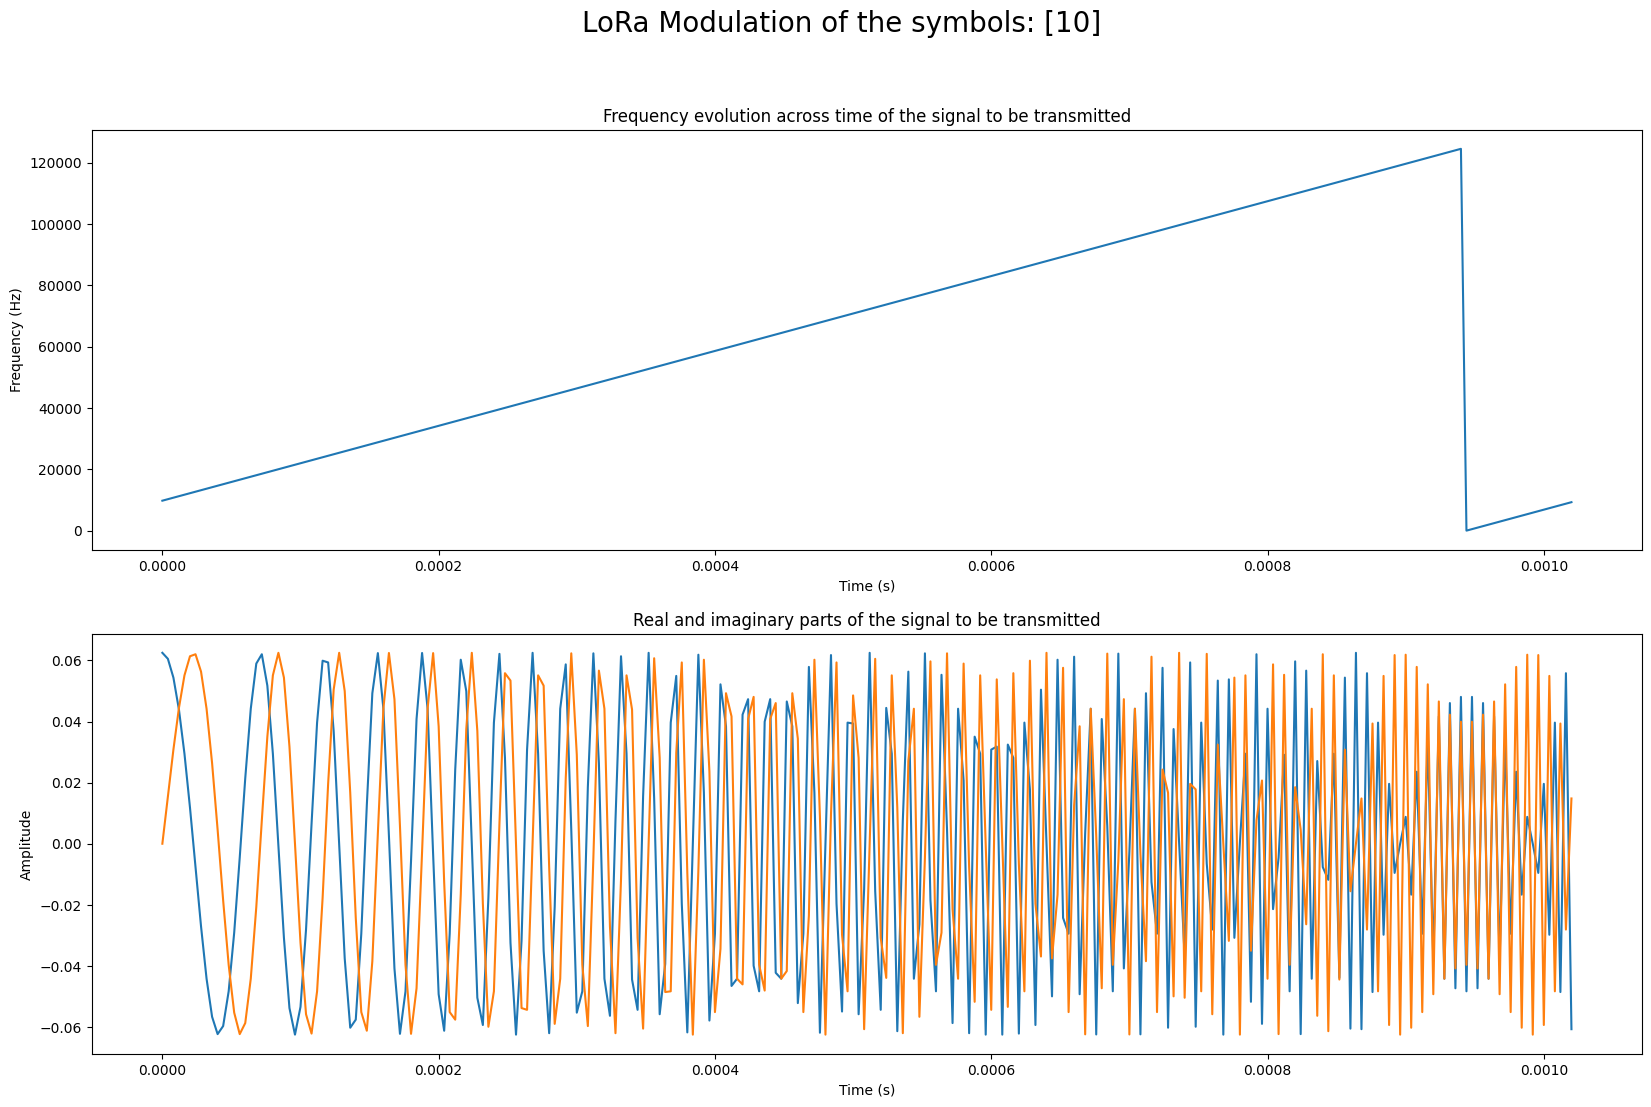

c:\Users\stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


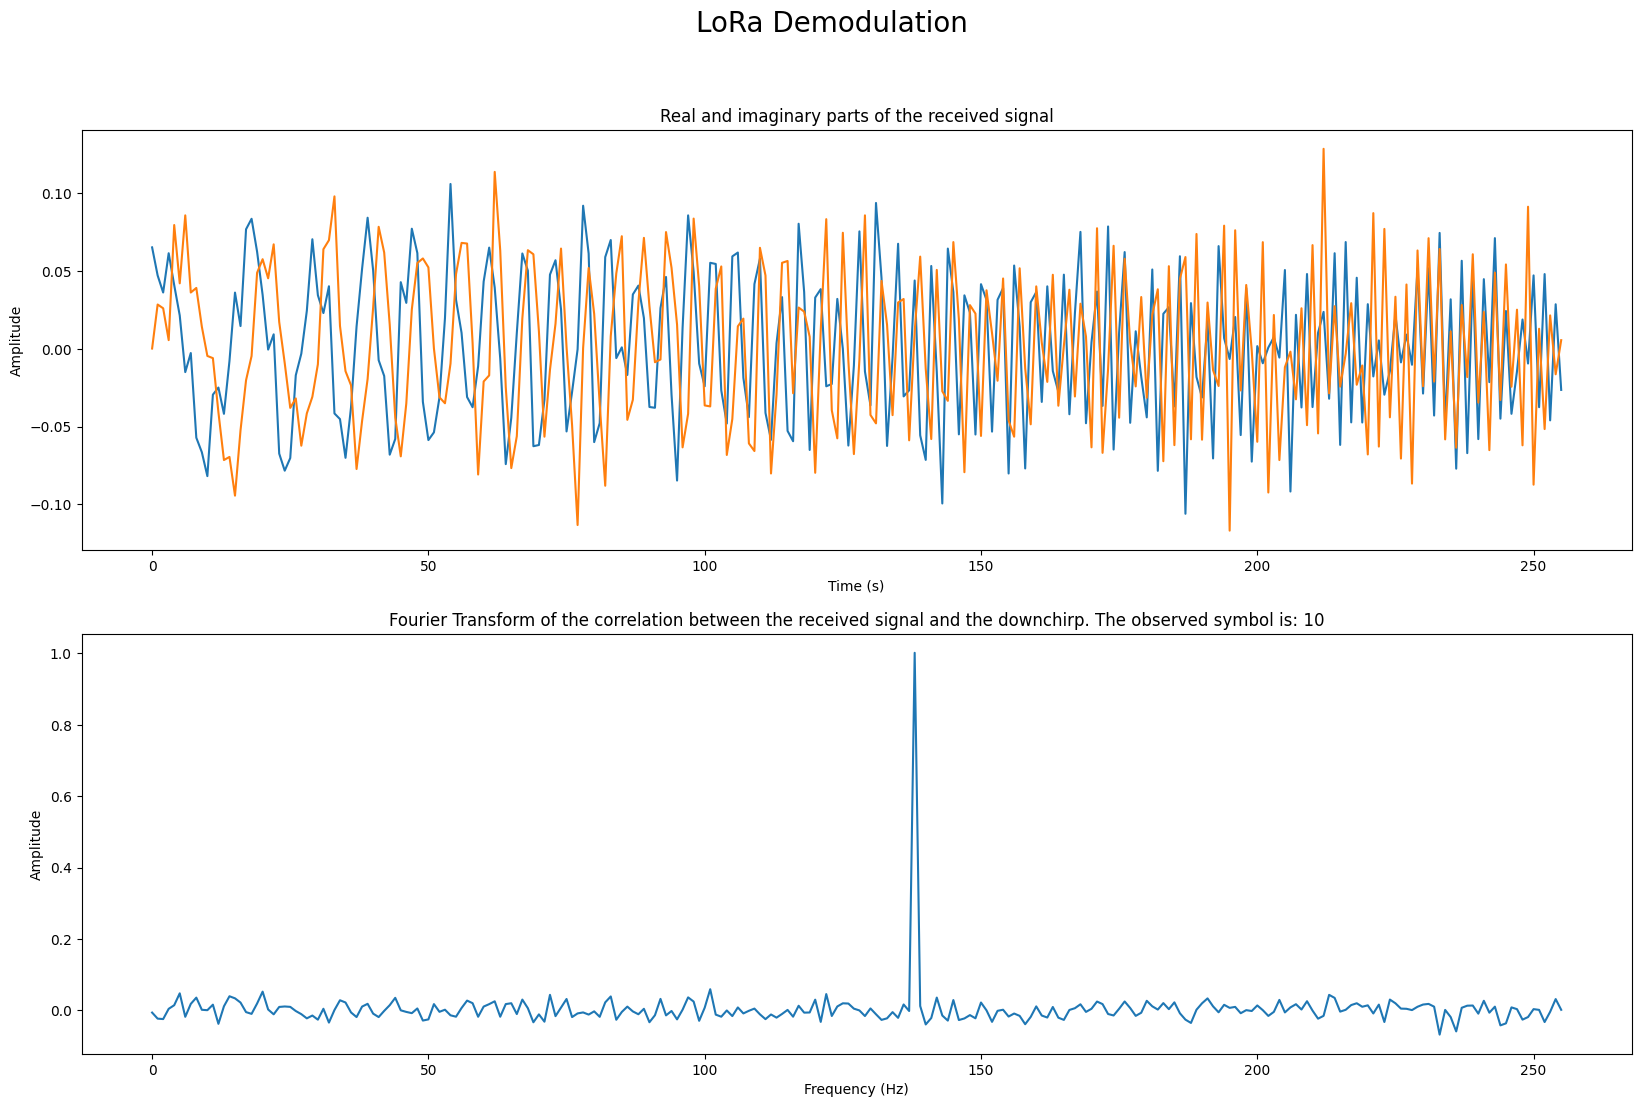

In [101]:
lora_modulator = LoraModulator(7, 125e3, 2)
lora_demodulator = LoraDemodulator(7, 125e3, 2)
symbol = [10]
timeline, frequency_evolution, signal = lora_modulator.modulate_symbols(symbol, also_compute_frequency_evolution = True, plot = True)
fig = lora_modulator.generate_modulation_plots(symbol, timeline, frequency_evolution, signal)
plt.show()
signal = generate_awgn('10dB', signal)[0]
demodulated_symbols, fft = lora_demodulator.demodulate_single_symbol(signal, True)
fig = lora_demodulator.generate_demodulation_plots(signal, fft)


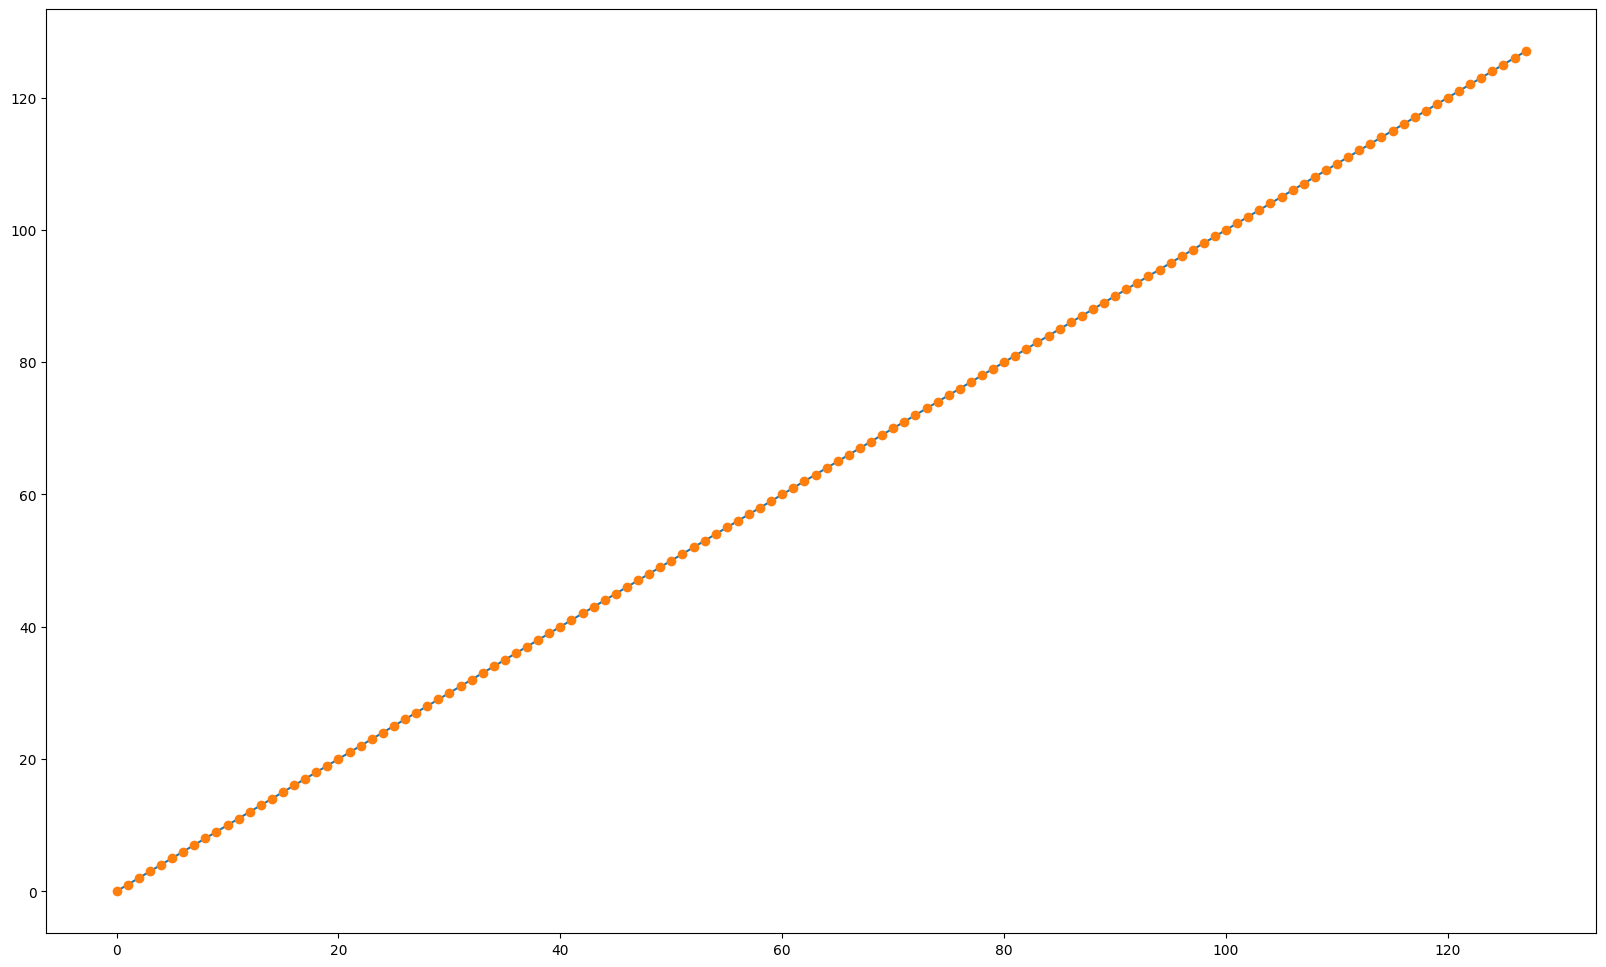

In [97]:
def test_all(samples_per_chip):
    lora_modulator = LoraModulator(7, 125e3, samples_per_chip)
    lora_demodulator = LoraDemodulator(7, 125e3, samples_per_chip)
    symbols = [i for i in range(128)]
    timeline, frequency_evolution, signal = lora_modulator.modulate_symbols(symbols, also_compute_frequency_evolution = True, plot = False)
    demodulated_symbols = lora_demodulator.demodulate_multiple_symbols(signal)
    return symbols, demodulated_symbols
symbols, demodulated_symbols = test_all(1)
plt.figure(figsize=(20, 12))
plt.plot(symbols, label='Original symbols')
plt.plot(demodulated_symbols, 'o',label='Demodulated symbols')